In [190]:
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

import re

# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

In [191]:
df = pd.read_csv('Дамп событий 2019-2022 utf8.csv', sep = ';', low_memory=False)

In [192]:
df.head()

,Номер животного,Ушная бирка животного,Пол,Номер лактации,Результат отела,Легкость отела,Дата рождения,Дней в сухостое предыдущей лактации,Дней стельности при событии,Номер группы животного,Предыдущий номер группы животного,Событие,Дни доения при событии,Дата события,Примечание события
0,146,598621616,F,6,FA,1,29.03.2010,62,277,18,18,РАСЧКОП,336,28.03.2019,КАН
1,146,598621616,F,6,FA,1,29.03.2010,62,277,18,18,ВАКЦИН,349,10.04.2019,КОГЛАВАК
2,146,598621616,F,6,FA,1,29.03.2010,62,277,18,18,ВАКЦИН,349,10.04.2019,ЛЕПТО
3,291,530073354,F,6,MA,1,30.07.2009,68,0,23,23,ПЕРЕВОД,448,08.04.2019,F001T023
4,291,530073354,F,6,MA,1,30.07.2009,68,0,23,23,ПРОДАНА,458,18.04.2019,ПРОДАНА ; Прочее ; УВЗ8


In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592307 entries, 0 to 592306
Data columns (total 15 columns):
 #   Column                               Non-Null Count   Dtype 
---  ------                               --------------   ----- 
 0   Номер животного                      592307 non-null  int64 
 1   Ушная бирка животного                592307 non-null  object
 2   Пол                                  592307 non-null  object
 3   Номер лактации                       592307 non-null  int64 
 4   Результат отела                      331357 non-null  object
 5   Легкость отела                       592307 non-null  int64 
 6   Дата рождения                        592307 non-null  object
 7   Дней в сухостое предыдущей лактации  592307 non-null  int64 
 8   Дней стельности при событии          592307 non-null  int64 
 9   Номер группы животного               592307 non-null  int64 
 10  Предыдущий номер группы животного    592307 non-null  int64 
 11  Событие                   

In [194]:
#преобразуем даты
df['Дата события'] = df['Дата события'].apply(lambda x: datetime.strptime(x,"%d.%m.%Y"))
df['Дата рождения'] = df['Дата рождения'].apply(lambda x: datetime.strptime(x,"%d.%m.%Y"))

In [195]:
#приведем события к единому виду
rename_mapping = {"ABORT":"АБОРТ",
"BRED":"ОСЕМЕН",
"DNB":"НЕОСЕМ",
"DRY":"СУХОСТ",
"FOOTRIM":"РАСЧКОП",
"FRESH":"ОТЕЛ",
"ILLMISC":"БОЛЕЗНЬ",
"KETOS":"КЕТОЗ",
"LAME":"ХРОМОТА",
"MAST":"МАСТИТ",
"METR":"МЕТРИТ",
"MOVE":"ПЕРЕВОД",
"NULSCM":"СО_СХЕМЫ",
"OPEN":"ЯЛОВАЯ",
"POT":"ПРОФОТ",
"RP":"ПОСЛЕД",
"SOLD":"ПРОДАНА",
"TOSCM":"НА_СХЕМУ",
"WEIGHT":"ВЕС",
"WELL":"ЗДОРОВА"}




df['Событие'] = df['Событие'].apply(lambda x: rename_mapping[x] if x in rename_mapping else x)

In [196]:
#выделим протокол лечения
df['protokol'] = df['Примечание события'].apply(lambda x: x.split('_')[0])

In [197]:
#список коров у которых хотя бы раз был статус здорова
recovered_cow = df[df['Событие'] == 'ЗДОРОВА']['Номер животного'].unique()
#recovered_cow
#столбец со статусом хотя бы раз была здорова
df['recovered_cow'] = df['Номер животного'].apply(lambda x: (x in (recovered_cow))*1)

In [198]:
#возраст коровы на мемент события
df['age'] = (df['Дата события'] - df['Дата рождения'])
df['age'] = df['age'].apply(lambda x: x.days)

In [199]:
#уникальные номара коров болевших маститом
cow_with_mastit = df[df['Событие'] == 'МАСТИТ']['Номер животного'].unique()

#отсортированная таблица событий с коровами болевшими маститом
df_cow_with_mastit = df.loc[df['Номер животного'].isin(cow_with_mastit)].sort_values(['Номер животного', 'Дата события'])
df_cow_with_mastit.tail(10)

,Номер животного,Ушная бирка животного,Пол,Номер лактации,Результат отела,Легкость отела,Дата рождения,Дней в сухостое предыдущей лактации,Дней стельности при событии,Номер группы животного,Предыдущий номер группы животного,Событие,Дни доения при событии,Дата события,Примечание события,protokol,recovered_cow,age
434891,912272,912272,F,1,FA,1,2019-12-31,0,0,44,43,ПРОФОТ,0,2021-09-30,ПРОФ2,ПРОФ2,1,639
434892,912272,912272,F,1,FA,1,2019-12-31,0,0,0,43,ОТЕЛ,0,2021-09-30,-,-,1,639
435247,912272,912272,F,1,FA,1,2019-12-31,0,0,44,43,ПЕРЕВОД,1,2021-10-01,F044T021,F044T021,1,640
435577,912272,912272,F,1,FA,1,2019-12-31,0,0,21,43,МАСТИТ,3,2021-10-03,ТМ6_4,ТМ6,1,642
437667,912272,912272,F,1,FA,1,2019-12-31,0,0,21,43,МАСТИТ,10,2021-10-10,ТМ1_1_4,ТМ1,1,649
440102,912272,912272,F,1,FA,1,2019-12-31,0,0,21,43,ЗДОРОВА,17,2021-10-17,ГИНЕКОЛ,ГИНЕКОЛ,1,656
440601,912272,912272,F,1,FA,1,2019-12-31,0,0,3,43,РАСЧКОП,18,2021-10-18,КАН,КАН,1,657
444127,912272,912272,F,1,FA,1,2019-12-31,0,0,3,43,ПЕРЕВОД,20,2021-10-20,F003T043,F003T043,1,659
446780,912272,912272,F,1,FA,1,2019-12-31,0,0,43,43,ПЕРЕВОД,25,2021-10-25,F043T050,F043T050,1,664
447392,912272,912272,F,1,FA,1,2019-12-31,0,0,50,43,ПРОДАНА,26,2021-10-26,ПРОДАНА ; Агалактия ; УВЗ9,ПРОДАНА ; Агалактия ; УВЗ9,1,665


In [200]:
grouped = df_cow_with_mastit.groupby('Номер животного').agg({'recovered_cow':'mean'})['recovered_cow']

print('Процент коров болевших МАСТИТ и имеющих статус ЗДОРОВА:', grouped.sum()/grouped.count()*100)

Процент коров болевших МАСТИТ и имеющих статус ЗДОРОВА: 95.5908926635345


In [201]:
grouped = grouped.reset_index()
grouped

,Номер животного,recovered_cow
0,321,1.0
1,675,0.0
2,784,1.0
3,871,1.0
4,1010,1.0
...,...,...
2762,912227,1.0
2763,912232,1.0
2764,912242,1.0
2765,912253,1.0


In [202]:
un_recovered_cow = grouped[grouped['recovered_cow']<1.0]['Номер животного'].unique()
len(un_recovered_cow)

122

In [203]:
pd.DataFrame(cow_with_mastit, columns = ['id']).to_csv('cow_with_mastit.csv', sep = ';')

In [204]:
print('Процент коров , болевших маститом:', len(cow_with_mastit)/len(df['Номер животного'].unique()))

Процент коров , болевших маститом: 0.1805900013053126


In [205]:
#загрузка файла с родителями
df_parents = pd.read_csv('parents.CSV', encoding = 'cp1251', error_bad_lines = False, header = 0, sep = ';')
df_parents.head(), len(df_parents)

(   Номер животного Ушная бирка животного  Номер Матери    Код Отца Отец Матери
 0                1             570034283             0  -           -         
 1                2             533487712             0  -           -         
 2                3             897733157             0  -           -         
 3                4             584322510             0  -           -         
 4                6             887578050             0  -           -         ,
 25498)

In [206]:
#талица родителей для коров болевших маститом
df_parents_mother = df_parents[df_parents['Номер животного'].isin(cow_with_mastit) & (df_parents['Номер Матери']!=0)]

In [207]:
print('Процент коров болевших маститом, у которых матери тоже болели маститом:', 
      len(df_parents_mother[df_parents_mother['Номер Матери'].isin(cow_with_mastit)])/len(df_parents_mother))

Процент коров болевших маститом, у которых матери тоже болели маститом: 0.33061828952239913


### Гипотеза - предрасположенность к маститу наследственна

Нулевая гипотеза: разницы в вероятности заболеть у коров рожденных коровами болевшими маститом и не болевшими маститом нет.
Альтернативная гипотеза: Вероятность заболеть у коров рожденных от коров болевших маститом больше.

In [208]:
#таблица коров у которых матери болели маститом
df_mather_with_mastit = df_parents[df_parents['Номер Матери'].isin(cow_with_mastit) & (df_parents['Номер Матери']!=0)]

In [209]:
print('Процент коров болевших маститом, при условии, что мать болела маститом:', 
      len(df_mather_with_mastit[df_mather_with_mastit['Номер животного'].isin(cow_with_mastit)])/len(df_mather_with_mastit))

Процент коров болевших маститом, при условии, что мать болела маститом: 0.12296887909666758


In [210]:
#таблица коров у которых матери не болели маститом
df_mather_without_mastit = df_parents[~df_parents['Номер Матери'].isin(cow_with_mastit) & (df_parents['Номер Матери']!=0)]

In [211]:
print('Процент коров болевших маститом, при условии, что мать не болела маститом:', 
      len(df_mather_without_mastit[df_mather_without_mastit['Номер животного'].isin(cow_with_mastit)])/len(df_mather_without_mastit))

Процент коров болевших маститом, при условии, что мать не болела маститом: 0.11683360258481422


In [212]:
import numpy as np
from scipy.stats import ttest_ind, fisher_exact

import warnings
warnings.filterwarnings('ignore')


df_mather_with_mastit['Болен'] = df_mather_with_mastit['Номер животного'] \
                                    .isin(cow_with_mastit).astype(np.int16)

df_mather_without_mastit['Болен'] = df_mather_without_mastit['Номер животного'] \
                                    .isin(cow_with_mastit).astype(np.int16)

dist_mastit = df_mather_with_mastit.Болен
dist_without_mastit = df_mather_without_mastit.Болен

print(f'P-value:\t{ttest_ind(dist_mastit, dist_without_mastit).pvalue}')

P-value:	0.18250075131577576


### Вывод

Процент коров болеющих маститом при условии что мать болела маститом сопоставим с процентом коров болеющих маститом при условии что мать не болела маститом. P-value:	0.18250075131577576, гипотезу о том что если мать болела маститом, то дочь имеет большую вероятность хаболеть маститом можно отвергнуть.

Группировки

In [213]:
df

,Номер животного,Ушная бирка животного,Пол,Номер лактации,Результат отела,Легкость отела,Дата рождения,Дней в сухостое предыдущей лактации,Дней стельности при событии,Номер группы животного,Предыдущий номер группы животного,Событие,Дни доения при событии,Дата события,Примечание события,protokol,recovered_cow,age
0,146,598621616,F,6,FA,1,2010-03-29,62,277,18,18,РАСЧКОП,336,2019-03-28,КАН,КАН,1,3286
1,146,598621616,F,6,FA,1,2010-03-29,62,277,18,18,ВАКЦИН,349,2019-04-10,КОГЛАВАК,КОГЛАВАК,1,3299
2,146,598621616,F,6,FA,1,2010-03-29,62,277,18,18,ВАКЦИН,349,2019-04-10,ЛЕПТО,ЛЕПТО,1,3299
3,291,530073354,F,6,MA,1,2009-07-30,68,0,23,23,ПЕРЕВОД,448,2019-04-08,F001T023,F001T023,0,3539
4,291,530073354,F,6,MA,1,2009-07-30,68,0,23,23,ПРОДАНА,458,2019-04-18,ПРОДАНА ; Прочее ; УВЗ8,ПРОДАНА ; Прочее ; УВЗ8,0,3549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592302,912269,912269,F,1,FA,1,2019-12-31,0,239,5,7,РАСЧКОП,274,2022-08-20,КАН,КАН,1,963
592303,912269,912269,F,1,FA,1,2019-12-31,0,239,5,7,ПЕРЕВОД,274,2022-08-20,F005T007,F005T007,1,963
592304,912269,912269,F,1,FA,1,2019-12-31,0,239,7,7,СУХОСТ,279,2022-08-25,-,-,1,968
592305,912270,912270,F,1,MA,1,2019-12-31,0,273,17,17,ВАКЦИН,313,2022-08-23,СКОУ,СКОУ,1,966


In [214]:
df['Месяц события'] = df['Дата события'].apply(lambda x: datetime(x.year, x.month, 1))

In [215]:
df_uniq = df.drop_duplicates(['Номер животного', 'Месяц события']).copy()
uniq_count = df_uniq.groupby('Месяц события').agg({'Номер животного':'count'}).reset_index() #число уникальных событий по месяцам
uniq_count

,Месяц события,Номер животного
0,2019-03-01,4330
1,2019-04-01,5056
2,2019-05-01,5137
3,2019-06-01,3610
4,2019-07-01,4809
5,2019-08-01,4753
6,2019-09-01,4900
7,2019-10-01,4136
8,2019-11-01,5392
9,2019-12-01,4739


In [216]:
mastit_count = df[df['Событие'] == 'МАСТИТ'].groupby('Месяц события').agg({'Номер животного':'count'}).reset_index()
mastit_count['Номер животного'].values

array([288, 170, 191, 226, 224, 264, 226, 202, 237, 277, 340, 335, 300,
       227, 188, 214, 200, 210, 214, 214, 186, 167, 168, 155, 232, 161,
       197, 197, 236, 254, 234, 179, 156,  96, 155, 128, 126,  84,  79,
       132, 126, 127,  46], dtype=int64)

Рассмотрим коров которых не удалось вылечить

In [217]:
df[df['Номер животного'].isin(list(grouped[grouped['recovered_cow']<1.0]['Номер животного']))].sort_values(['Номер животного', 'Дата события'])['Номер животного'].unique()

array([   675,   1283,   4258,   5023,   5094,   6219,   7061,   7162,
         7181,   8001,   8044,   8144,   8191,   8234,   9004,   9066,
         9127,   9180,   9201,  10074,  10152,  10211,  10215,  11096,
        11131,  11167, 202053, 208056, 210265, 212022, 304051, 308124,
       309037, 311065, 311068, 311103, 312039, 312163, 400171, 401023,
       402056, 402083, 402141, 402178, 402180, 403027, 403076, 403180,
       404030, 404073, 405025, 405078, 405087, 407100, 408014, 408019,
       408051, 408112, 409060, 410024, 410118, 412079, 501037, 501116,
       501128, 503019, 503083, 503123, 503159, 504082, 504084, 507093,
       508041, 509125, 510016, 512024, 603016, 603075, 603132, 604101,
       604152, 605103, 607057, 608060, 608098, 608109, 609063, 611034,
       611081, 701158, 702049, 702674, 703056, 706031, 706154, 707058,
       708147, 708197, 711134, 712092, 801076, 802043, 805097, 805112,
       805130, 808022, 808075, 809154, 811109, 812116, 902013, 902209,
      

In [218]:
unrecovered_cow = df[df['Номер животного'].isin(list(grouped[grouped['recovered_cow']<1.0]['Номер животного']))].sort_values(['Номер животного', 'Дата события'])

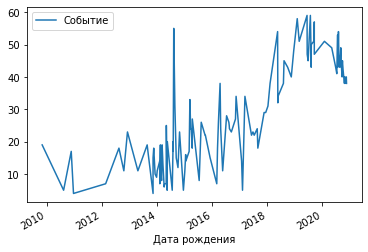

In [219]:
unrecovered_cow.groupby('Номер животного').agg({'Событие':'count', 'Дата рождения':'max'}).sort_values('Дата рождения').plot(y = 'Событие', x = 'Дата рождения')
plt.show()

In [220]:
#уникальные номара коров болевших маститом
cow_with_mastit = df[df['Событие'] == 'МАСТИТ']['Номер животного'].unique()

#отсортированная таблица событий с коровами болевшими маститом
df_cow_with_mastit = df.loc[df['Номер животного'].isin(cow_with_mastit)].sort_values(['Номер животного', 'Дата события'])
df_cow_with_mastit.tail(10)

,Номер животного,Ушная бирка животного,Пол,Номер лактации,Результат отела,Легкость отела,Дата рождения,Дней в сухостое предыдущей лактации,Дней стельности при событии,Номер группы животного,Предыдущий номер группы животного,Событие,Дни доения при событии,Дата события,Примечание события,protokol,recovered_cow,age,Месяц события
434891,912272,912272,F,1,FA,1,2019-12-31,0,0,44,43,ПРОФОТ,0,2021-09-30,ПРОФ2,ПРОФ2,1,639,2021-09-01
434892,912272,912272,F,1,FA,1,2019-12-31,0,0,0,43,ОТЕЛ,0,2021-09-30,-,-,1,639,2021-09-01
435247,912272,912272,F,1,FA,1,2019-12-31,0,0,44,43,ПЕРЕВОД,1,2021-10-01,F044T021,F044T021,1,640,2021-10-01
435577,912272,912272,F,1,FA,1,2019-12-31,0,0,21,43,МАСТИТ,3,2021-10-03,ТМ6_4,ТМ6,1,642,2021-10-01
437667,912272,912272,F,1,FA,1,2019-12-31,0,0,21,43,МАСТИТ,10,2021-10-10,ТМ1_1_4,ТМ1,1,649,2021-10-01
440102,912272,912272,F,1,FA,1,2019-12-31,0,0,21,43,ЗДОРОВА,17,2021-10-17,ГИНЕКОЛ,ГИНЕКОЛ,1,656,2021-10-01
440601,912272,912272,F,1,FA,1,2019-12-31,0,0,3,43,РАСЧКОП,18,2021-10-18,КАН,КАН,1,657,2021-10-01
444127,912272,912272,F,1,FA,1,2019-12-31,0,0,3,43,ПЕРЕВОД,20,2021-10-20,F003T043,F003T043,1,659,2021-10-01
446780,912272,912272,F,1,FA,1,2019-12-31,0,0,43,43,ПЕРЕВОД,25,2021-10-25,F043T050,F043T050,1,664,2021-10-01
447392,912272,912272,F,1,FA,1,2019-12-31,0,0,50,43,ПРОДАНА,26,2021-10-26,ПРОДАНА ; Агалактия ; УВЗ9,ПРОДАНА ; Агалактия ; УВЗ9,1,665,2021-10-01


In [221]:
def part_return(row):
    if row['Событие']!='МАСТИТ':
        return '0 0 0 0'
    else:
        if row['Примечание события'] == 'МВ':
            return '0 0 0 0'
        else:
            tmp = str(row['Примечание события'].split('_')[1:])
            if (tmp == "['3', '4']") | (tmp == "['34']") | (tmp == "['3,4']"):
                return '0 0 1 1'
            elif (tmp == "['134']") :
                return '1 0 1 1'
            elif (tmp == "['2']") :
                return '0 1 0 0'
            elif (tmp == "['24']") | (tmp == "['?24']") | (tmp == "['2,4']"):
                return '0 1 0 1'
            if (tmp == "['1', '4']") | (tmp == "['?']") | (tmp == "['1-4']") | (tmp == "['T']"):
                return '1 1 1 1'
            elif (tmp == "['1']") :
                return '1 0 0 0'
            if (tmp == "['14']") | (tmp == "['1,4']") | (tmp == "['1,4,']"):
                return '1 0 0 1'
            elif (tmp == "['3']") | (tmp == "[',3']"):
                return '0 0 1 0'
            elif (tmp == "['4']") | (tmp == "['?4']") | (tmp == "['4,']"):
                return '0 0 0 1'
            elif (tmp == "['23']") | (tmp == "['2,3']") | (tmp == "['?23']"):
                return '0 1 1 0'
            elif (tmp == "['12']") | (tmp == "['1,2']") :
                return '1 1 0 0'
            elif (tmp == "['2-4']") | (tmp == "['234']") :
                return '0 1 1 1'
            elif (tmp == "['124']") :
                return '1 1 0 1'
            elif (tmp == "['123']") | (tmp == "['1-3']") :
                return '1 1 1 0'
            elif (tmp == "['13']") | (tmp == "['1,3']") :
                return '1 0 1 0'
            elif (tmp == "['']") | (tmp == '[]') | (tmp == "['6']") :
                return '0 0 0 0'
            elif (tmp == "['43']") :
                return '0 0 1 1'
            else:
                return tmp

In [222]:
df_cow_with_mastit['part_1'] = df_cow_with_mastit.apply(part_return, axis = 1)

In [223]:
df_cow_with_mastit

,Номер животного,Ушная бирка животного,Пол,Номер лактации,Результат отела,Легкость отела,Дата рождения,Дней в сухостое предыдущей лактации,Дней стельности при событии,Номер группы животного,Предыдущий номер группы животного,Событие,Дни доения при событии,Дата события,Примечание события,protokol,recovered_cow,age,Месяц события,part_1
5,321,896820302,F,6,FA,3,2009-09-11,62,291,18,18,МАСТИТ,213,2019-03-15,МВ,МВ,1,3472,2019-03-01,0 0 0 0
6,321,896820302,F,6,FA,3,2009-09-11,62,291,18,18,МАСТИТ,215,2019-03-17,ТМ6_34,ТМ6,1,3474,2019-03-01,0 0 1 1
7,321,896820302,F,6,FA,3,2009-09-11,62,291,18,18,ПЕРЕВОД,216,2019-03-18,F006T003,F006T003,1,3475,2019-03-01,0 0 0 0
8,321,896820302,F,6,FA,3,2009-09-11,62,291,18,18,МАСТИТ,221,2019-03-23,КМ4_134,КМ4,1,3480,2019-03-01,1 0 1 1
9,321,896820302,F,6,FA,3,2009-09-11,62,291,18,18,ЗДОРОВА,230,2019-04-01,МАСТИТ,МАСТИТ,1,3489,2019-04-01,0 0 0 0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440102,912272,912272,F,1,FA,1,2019-12-31,0,0,21,43,ЗДОРОВА,17,2021-10-17,ГИНЕКОЛ,ГИНЕКОЛ,1,656,2021-10-01,0 0 0 0
440601,912272,912272,F,1,FA,1,2019-12-31,0,0,3,43,РАСЧКОП,18,2021-10-18,КАН,КАН,1,657,2021-10-01,0 0 0 0
444127,912272,912272,F,1,FA,1,2019-12-31,0,0,3,43,ПЕРЕВОД,20,2021-10-20,F003T043,F003T043,1,659,2021-10-01,0 0 0 0
446780,912272,912272,F,1,FA,1,2019-12-31,0,0,43,43,ПЕРЕВОД,25,2021-10-25,F043T050,F043T050,1,664,2021-10-01,0 0 0 0


In [224]:
df_cow_with_mastit = pd.concat([df_cow_with_mastit, pd.DataFrame(df_cow_with_mastit['part_1'].str.split().tolist(), columns = ['p1', 'p2', 'p3', 'p4'], index = df_cow_with_mastit.index)], axis = 1, join='outer')

In [225]:
df_cow_with_mastit = df_cow_with_mastit.drop(['part_1'], axis = 1)

In [226]:
df_cow_with_mastit = df_cow_with_mastit.drop(['Номер группы животного', 'Предыдущий номер группы животного'], axis = 1)

In [227]:
df_cow_with_mastit['p1'] = df_cow_with_mastit['p1'].astype(int)
df_cow_with_mastit['p2'] = df_cow_with_mastit['p2'].astype(int)
df_cow_with_mastit['p3'] = df_cow_with_mastit['p3'].astype(int)
df_cow_with_mastit['p4'] = df_cow_with_mastit['p4'].astype(int)
df_cow_with_mastit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225621 entries, 5 to 447392
Data columns (total 21 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   Номер животного                      225621 non-null  int64         
 1   Ушная бирка животного                225621 non-null  object        
 2   Пол                                  225621 non-null  object        
 3   Номер лактации                       225621 non-null  int64         
 4   Результат отела                      176312 non-null  object        
 5   Легкость отела                       225621 non-null  int64         
 6   Дата рождения                        225621 non-null  datetime64[ns]
 7   Дней в сухостое предыдущей лактации  225621 non-null  int64         
 8   Дней стельности при событии          225621 non-null  int64         
 9   Событие                              225621 non-null  object        
 

In [228]:
def struck(row):
    return (row['p1']+row['p2']+row['p3']+row['p4'])

df_cow_with_mastit['struck'] = df_cow_with_mastit.apply(struck, axis = 1)
df_cow_with_mastit

,Номер животного,Ушная бирка животного,Пол,Номер лактации,Результат отела,Легкость отела,Дата рождения,Дней в сухостое предыдущей лактации,Дней стельности при событии,Событие,Дни доения при событии,Дата события,Примечание события,protokol,recovered_cow,age,Месяц события,p1,p2,p3,p4,struck
5,321,896820302,F,6,FA,3,2009-09-11,62,291,МАСТИТ,213,2019-03-15,МВ,МВ,1,3472,2019-03-01,0,0,0,0,0
6,321,896820302,F,6,FA,3,2009-09-11,62,291,МАСТИТ,215,2019-03-17,ТМ6_34,ТМ6,1,3474,2019-03-01,0,0,1,1,2
7,321,896820302,F,6,FA,3,2009-09-11,62,291,ПЕРЕВОД,216,2019-03-18,F006T003,F006T003,1,3475,2019-03-01,0,0,0,0,0
8,321,896820302,F,6,FA,3,2009-09-11,62,291,МАСТИТ,221,2019-03-23,КМ4_134,КМ4,1,3480,2019-03-01,1,0,1,1,3
9,321,896820302,F,6,FA,3,2009-09-11,62,291,ЗДОРОВА,230,2019-04-01,МАСТИТ,МАСТИТ,1,3489,2019-04-01,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440102,912272,912272,F,1,FA,1,2019-12-31,0,0,ЗДОРОВА,17,2021-10-17,ГИНЕКОЛ,ГИНЕКОЛ,1,656,2021-10-01,0,0,0,0,0
440601,912272,912272,F,1,FA,1,2019-12-31,0,0,РАСЧКОП,18,2021-10-18,КАН,КАН,1,657,2021-10-01,0,0,0,0,0
444127,912272,912272,F,1,FA,1,2019-12-31,0,0,ПЕРЕВОД,20,2021-10-20,F003T043,F003T043,1,659,2021-10-01,0,0,0,0,0
446780,912272,912272,F,1,FA,1,2019-12-31,0,0,ПЕРЕВОД,25,2021-10-25,F043T050,F043T050,1,664,2021-10-01,0,0,0,0,0


In [229]:
df_cow_with_mastit = df_cow_with_mastit.reset_index()

In [230]:
df_cow_with_mastit['result'] = 'БОЛЕЕТ'
for i in range(len(df_cow_with_mastit)):
    if df_cow_with_mastit.loc[i, 'Событие'] == 'МАСТИТ':
        if (df_cow_with_mastit.loc[i+1, 'Событие'] == 'ЗДОРОВА') & (df_cow_with_mastit.loc[i+1, 'Примечание события'] == 'МАСТИТ'):
            df_cow_with_mastit.loc[i, 'result'] = 'ЗДОРОВА' #df_cow_with_mastit.loc[i, 'struck']
        elif df_cow_with_mastit.loc[i+1, 'Событие'] == 'МАСТИТ':
            df_cow_with_mastit.loc[i, 'result'] = df_cow_with_mastit.loc[i+1, 'protokol']
        elif (df_cow_with_mastit.loc[i+1, 'Событие'] == 'АБОРТ') | (df_cow_with_mastit.loc[i+1, 'Событие'] == 'ГИНЕКОЛ'):
                df_cow_with_mastit.loc[i, 'result'] = df_cow_with_mastit.loc[i, 'protokol']
        elif df_cow_with_mastit.loc[i+1, 'Событие'] == 'ПЕРЕВОД':
            if df_cow_with_mastit.loc[i+2, 'Событие'] == 'МАСТИТ':
                df_cow_with_mastit.loc[i, 'result'] = df_cow_with_mastit.loc[i+2, 'protokol']
            if (df_cow_with_mastit.loc[i+2, 'Событие'] == 'АБОРТ') | (df_cow_with_mastit.loc[i+2, 'Событие'] == 'ГИНЕКОЛ'):
                df_cow_with_mastit.loc[i, 'result'] = df_cow_with_mastit.loc[i, 'protokol']
        else:
            df_cow_with_mastit.loc[i, 'result'] = df_cow_with_mastit.loc[i, 'protokol']

In [151]:
df_cow_with_mastit[df_cow_with_mastit['Событие'] == 'МАСТИТ']

,index,Номер животного,Ушная бирка животного,Пол,Номер лактации,Результат отела,Легкость отела,Дата рождения,Дней в сухостое предыдущей лактации,Дней стельности при событии,Событие,Дни доения при событии,Дата события,Примечание события,protokol,recovered_cow,age,Месяц события,p1,p2,p3,p4,struck,result
0,5,321,896820302,F,6,FA,3,2009-09-11,62,291,МАСТИТ,213,2019-03-15,МВ,МВ,1,3472,2019-03-01,0,0,0,0,0,ТМ6
1,6,321,896820302,F,6,FA,3,2009-09-11,62,291,МАСТИТ,215,2019-03-17,ТМ6_34,ТМ6,1,3474,2019-03-01,0,0,1,1,2,КМ4
3,8,321,896820302,F,6,FA,3,2009-09-11,62,291,МАСТИТ,221,2019-03-23,КМ4_134,КМ4,1,3480,2019-03-01,1,0,1,1,3,ЗДОРОВА
43,44605,675,531779097,F,7,FD,1,2009-11-02,60,0,МАСТИТ,294,2019-07-14,КМ5_2,КМ5,0,3541,2019-07-01,0,1,0,0,1,БОЛЕЕТ
46,44608,675,531779097,F,7,FD,1,2009-11-02,60,0,МАСТИТ,302,2019-07-22,КМ4_2,КМ4,0,3549,2019-07-01,0,1,0,0,1,КМ5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225397,505548,912232,912232,F,1,MD,3,2019-12-27,0,0,МАСТИТ,80,2022-03-04,КМ1_3,КМ1,1,798,2022-03-01,0,0,1,0,1,КМ1
225473,502335,912242,912242,F,1,FA,1,2019-12-29,0,104,МАСТИТ,118,2022-02-24,КМ1_4,КМ1,1,788,2022-02-01,0,0,0,1,1,БОЛЕЕТ
225562,574002,912253,912253,F,1,FA,1,2019-12-30,0,264,МАСТИТ,277,2022-07-27,КМ1_1,КМ1,1,940,2022-07-01,1,0,0,0,1,БОЛЕЕТ
225614,435577,912272,912272,F,1,FA,1,2019-12-31,0,0,МАСТИТ,3,2021-10-03,ТМ6_4,ТМ6,1,642,2021-10-01,0,0,0,1,1,ТМ1


In [152]:
df_cow_with_mastit = df_cow_with_mastit.drop(['Месяц события', 'Дата события', 'index', 'Ушная бирка животного'], axis = 1)
df_cow_with_mastit

,Номер животного,Пол,Номер лактации,Результат отела,Легкость отела,Дата рождения,Дней в сухостое предыдущей лактации,Дней стельности при событии,Событие,Дни доения при событии,Примечание события,protokol,recovered_cow,age,p1,p2,p3,p4,struck,result
0,321,F,6,FA,3,2009-09-11,62,291,МАСТИТ,213,МВ,МВ,1,3472,0,0,0,0,0,ТМ6
1,321,F,6,FA,3,2009-09-11,62,291,МАСТИТ,215,ТМ6_34,ТМ6,1,3474,0,0,1,1,2,КМ4
2,321,F,6,FA,3,2009-09-11,62,291,ПЕРЕВОД,216,F006T003,F006T003,1,3475,0,0,0,0,0,БОЛЕЕТ
3,321,F,6,FA,3,2009-09-11,62,291,МАСТИТ,221,КМ4_134,КМ4,1,3480,1,0,1,1,3,ЗДОРОВА
4,321,F,6,FA,3,2009-09-11,62,291,ЗДОРОВА,230,МАСТИТ,МАСТИТ,1,3489,0,0,0,0,0,БОЛЕЕТ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225616,912272,F,1,FA,1,2019-12-31,0,0,ЗДОРОВА,17,ГИНЕКОЛ,ГИНЕКОЛ,1,656,0,0,0,0,0,БОЛЕЕТ
225617,912272,F,1,FA,1,2019-12-31,0,0,РАСЧКОП,18,КАН,КАН,1,657,0,0,0,0,0,БОЛЕЕТ
225618,912272,F,1,FA,1,2019-12-31,0,0,ПЕРЕВОД,20,F003T043,F003T043,1,659,0,0,0,0,0,БОЛЕЕТ
225619,912272,F,1,FA,1,2019-12-31,0,0,ПЕРЕВОД,25,F043T050,F043T050,1,664,0,0,0,0,0,БОЛЕЕТ


In [168]:
df_cow_model = df_cow_with_mastit[df_cow_with_mastit['Событие'] == 'МАСТИТ'].copy()

In [ ]:
df_cow_with_mastit.

#### НОВЫЙ ТАРГЕТ

In [169]:
df_cow_model['result'] = df_cow_model['result'].apply(lambda x: re.sub('СКМ[0-9]', 'СРЕДНЕЕ', x))
df_cow_model['result'] = df_cow_model['result'].apply(lambda x: re.sub('КМ[0-9]', 'ТЯЖЕЛОЕ', x))
df_cow_model['result'] = df_cow_model['result'].apply(lambda x: re.sub('ТМ[0-9]', 'ТРАВМА', x))
df_cow_model['result'] = df_cow_model['result'].apply(lambda x: re.sub('MB', 'ЛЕГКОЕ', x))
df_cow_model['result'] = df_cow_model['result'].apply(lambda x: re.sub('МВ', 'ЛЕГКОЕ', x))
df_cow_model['result'].unique()

array(['ТРАВМА', 'ТЯЖЕЛОЕ', 'ЗДОРОВА', 'БОЛЕЕТ', 'ЛЕГКОЕ', 'СРЕДНЕЕ'],
      dtype=object)

In [170]:
df_cow_model = df_cow_model.drop(['Пол', 'Дата рождения', 'Событие', 'Примечание события', 'recovered_cow'], axis = 1)
df_cow_model

,Номер животного,Номер лактации,Результат отела,Легкость отела,Дней в сухостое предыдущей лактации,Дней стельности при событии,Дни доения при событии,protokol,age,p1,p2,p3,p4,struck,result
0,321,6,FA,3,62,291,213,МВ,3472,0,0,0,0,0,ТРАВМА
1,321,6,FA,3,62,291,215,ТМ6,3474,0,0,1,1,2,ТЯЖЕЛОЕ
3,321,6,FA,3,62,291,221,КМ4,3480,1,0,1,1,3,ЗДОРОВА
43,675,7,FD,1,60,0,294,КМ5,3541,0,1,0,0,1,БОЛЕЕТ
46,675,7,FD,1,60,0,302,КМ4,3549,0,1,0,0,1,ТЯЖЕЛОЕ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225397,912232,1,MD,3,0,0,80,КМ1,798,0,0,1,0,1,ТЯЖЕЛОЕ
225473,912242,1,FA,1,0,104,118,КМ1,788,0,0,0,1,1,БОЛЕЕТ
225562,912253,1,FA,1,0,264,277,КМ1,940,1,0,0,0,1,БОЛЕЕТ
225614,912272,1,FA,1,0,0,3,ТМ6,642,0,0,0,1,1,ТРАВМА


In [171]:
df_cow_model = df_cow_model.reset_index(drop = True)

In [172]:
df_cow_model['stage'] = 0
for i in range(1, len(df_cow_model)):
    if df_cow_model.loc[i-1, 'Номер животного'] == df_cow_model.loc[i, 'Номер животного']:
        df_cow_model.loc[i, 'stage'] = df_cow_model.loc[i-1, 'stage']+1
df_cow_model

,Номер животного,Номер лактации,Результат отела,Легкость отела,Дней в сухостое предыдущей лактации,Дней стельности при событии,Дни доения при событии,protokol,age,p1,p2,p3,p4,struck,result,stage
0,321,6,FA,3,62,291,213,МВ,3472,0,0,0,0,0,ТРАВМА,0
1,321,6,FA,3,62,291,215,ТМ6,3474,0,0,1,1,2,ТЯЖЕЛОЕ,1
2,321,6,FA,3,62,291,221,КМ4,3480,1,0,1,1,3,ЗДОРОВА,2
3,675,7,FD,1,60,0,294,КМ5,3541,0,1,0,0,1,БОЛЕЕТ,0
4,675,7,FD,1,60,0,302,КМ4,3549,0,1,0,0,1,ТЯЖЕЛОЕ,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8363,912232,1,MD,3,0,0,80,КМ1,798,0,0,1,0,1,ТЯЖЕЛОЕ,0
8364,912242,1,FA,1,0,104,118,КМ1,788,0,0,0,1,1,БОЛЕЕТ,0
8365,912253,1,FA,1,0,264,277,КМ1,940,1,0,0,0,1,БОЛЕЕТ,0
8366,912272,1,FA,1,0,0,3,ТМ6,642,0,0,0,1,1,ТРАВМА,0


In [173]:
df_cow_model = df_cow_model.drop(['Номер животного', 'Результат отела'], axis = 1)

In [174]:
df_cow_model['struck'] = df_cow_model['struck'].astype("object").astype("category")
df_cow_model['protokol'] = df_cow_model['protokol'].astype("object").astype("category")
df_cow_model['stage'] = df_cow_model['stage'].astype("object").astype("category")
df_cow_model['result'] = df_cow_model['result'].astype("object").astype("category")

In [189]:
df_cow_model.head(50)

,Номер лактации,Легкость отела,Дней в сухостое предыдущей лактации,Дней стельности при событии,Дни доения при событии,protokol,age,p1,p2,p3,p4,struck,result,stage
0,6,3,62,291,213,МВ,3472,0,0,0,0,0,ТРАВМА,0
1,6,3,62,291,215,ТМ6,3474,0,0,1,1,2,ТЯЖЕЛОЕ,1
2,6,3,62,291,221,КМ4,3480,1,0,1,1,3,ЗДОРОВА,2
3,7,1,60,0,294,КМ5,3541,0,1,0,0,1,БОЛЕЕТ,0
4,7,1,60,0,302,КМ4,3549,0,1,0,0,1,ТЯЖЕЛОЕ,1
5,7,1,60,0,310,КМ5,3557,0,1,0,0,1,ТЯЖЕЛОЕ,2
6,7,1,60,0,324,КМ5,3571,0,1,0,1,2,ТЯЖЕЛОЕ,3
7,8,1,62,0,103,КМ4,3366,1,1,1,1,4,БОЛЕЕТ,0
8,6,3,60,287,246,КМ1,3359,1,0,0,0,1,БОЛЕЕТ,0
9,1,1,0,154,275,КМ6,949,1,0,0,1,2,БОЛЕЕТ,0


In [175]:
#Разделим данные на признаки а целефой столббец
X = df_cow_model.drop('result', axis = 1)
y = df_cow_model['result']

#разделим данные на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42)
print('X - Train size:', X_train.shape)
print('X - Test size:', X_test.shape)
#print('X - Validation size:', X_val.shape)
print('y - Train size:', y_train.shape)
print('y - Test size:', y_test.shape)
#print('y - Validation size:', y_val.shape)

X - Train size: (6694, 13)
X - Test size: (1674, 13)
y - Train size: (6694,)
y - Test size: (1674,)


In [176]:
#отключим предупреждения
pd.options.mode.chained_assignment = None
numeric = ['Номер лактации', 'Легкость отела', 'Дней в сухостое предыдущей лактации', 'Дней стельности при событии', 'Дни доения при событии', 'age']
#инициализация StandardScaler
scaler = StandardScaler()
#скалер обучаем только на трейне
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])
#X_val[numeric] = scaler.transform(X_val[numeric])

In [177]:
category = ['protokol', 'struck', 'stage']


In [178]:
X_train[X_train['stage'] == 0]

,Номер лактации,Легкость отела,Дней в сухостое предыдущей лактации,Дней стельности при событии,Дни доения при событии,protokol,age,p1,p2,p3,p4,struck,stage
7356,-1.108976,-0.308627,-1.500305,-0.887718,1.369175,МВ,-0.732563,0,0,0,0,0,0
208,-1.108976,-0.308627,-1.500305,-0.887718,-1.307444,КМ3,-1.300459,0,0,1,1,2,0
747,1.318587,-0.308627,0.597491,-0.887718,-1.221716,МВ,1.069890,0,0,0,0,0,0
798,2.127774,-0.308627,0.528711,-0.887718,-0.726399,КМ3,1.736550,1,1,0,0,2,0
5597,-1.108976,-0.308627,-1.500305,-0.887718,-0.878804,МВ,-1.222587,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2433,-0.299789,-0.308627,0.838221,-0.887718,-0.345385,МВ,0.152519,0,0,0,0,0,0
6949,-1.108976,-0.308627,-1.500305,-0.887718,-1.212191,КМ4,-1.336546,0,0,0,1,1,0
8322,-1.108976,-0.308627,-1.500305,1.427304,1.702562,КМ1,-0.721167,1,0,0,0,1,0
5578,-0.299789,-0.308627,0.459930,-0.304016,-0.669247,ТМ9,-0.403981,0,0,0,1,1,0


In [179]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(cat_features = category, iterations = 824, depth = 3, loss_function = 'MultiClassOneVsAll')

model.fit(X_train, y_train, eval_set=[(X_test, y_test)], plot = True)
predictions = model.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6774797	test: 0.6771717	best: 0.6771717 (0)	total: 55.2ms	remaining: 45.4s
1:	learn: 0.6618079	test: 0.6615601	best: 0.6615601 (1)	total: 97.7ms	remaining: 40.1s
2:	learn: 0.6470816	test: 0.6468777	best: 0.6468777 (2)	total: 137ms	remaining: 37.6s
3:	learn: 0.6331646	test: 0.6330364	best: 0.6330364 (3)	total: 220ms	remaining: 45.2s
4:	learn: 0.6202848	test: 0.6200969	best: 0.6200969 (4)	total: 274ms	remaining: 44.9s
5:	learn: 0.6079125	test: 0.6077153	best: 0.6077153 (5)	total: 311ms	remaining: 42.5s
6:	learn: 0.5961569	test: 0.5959938	best: 0.5959938 (6)	total: 365ms	remaining: 42.6s
7:	learn: 0.5849384	test: 0.5848282	best: 0.5848282 (7)	total: 403ms	remaining: 41.1s
8:	learn: 0.5742588	test: 0.5741902	best: 0.5741902 (8)	total: 441ms	remaining: 39.9s
9:	learn: 0.5640802	test: 0.5640705	best: 0.5640705 (9)	total: 487ms	remaining: 39.6s
10:	learn: 0.5544306	test: 0.5545056	best: 0.5545056 (10)	total: 530ms	remaining: 39.2s
11:	learn: 0.5452706	test: 0.5454275	best: 0.54542

98:	learn: 0.3258995	test: 0.3309086	best: 0.3309086 (98)	total: 5.56s	remaining: 40.7s
99:	learn: 0.3255337	test: 0.3305844	best: 0.3305844 (99)	total: 5.6s	remaining: 40.6s
100:	learn: 0.3251011	test: 0.3302124	best: 0.3302124 (100)	total: 5.64s	remaining: 40.4s
101:	learn: 0.3247644	test: 0.3299066	best: 0.3299066 (101)	total: 5.68s	remaining: 40.2s
102:	learn: 0.3244707	test: 0.3296251	best: 0.3296251 (102)	total: 5.73s	remaining: 40.1s
103:	learn: 0.3240811	test: 0.3292621	best: 0.3292621 (103)	total: 5.78s	remaining: 40s
104:	learn: 0.3237561	test: 0.3289535	best: 0.3289535 (104)	total: 5.83s	remaining: 39.9s
105:	learn: 0.3236061	test: 0.3288141	best: 0.3288141 (105)	total: 5.87s	remaining: 39.8s
106:	learn: 0.3232569	test: 0.3285097	best: 0.3285097 (106)	total: 5.92s	remaining: 39.6s
107:	learn: 0.3230556	test: 0.3283519	best: 0.3283519 (107)	total: 5.97s	remaining: 39.6s
108:	learn: 0.3227430	test: 0.3280875	best: 0.3280875 (108)	total: 6.03s	remaining: 39.5s
109:	learn: 0.322

190:	learn: 0.3113742	test: 0.3194385	best: 0.3194370 (189)	total: 10.2s	remaining: 33.7s
191:	learn: 0.3112789	test: 0.3193632	best: 0.3193632 (191)	total: 10.2s	remaining: 33.6s
192:	learn: 0.3112169	test: 0.3193617	best: 0.3193617 (192)	total: 10.3s	remaining: 33.6s
193:	learn: 0.3111338	test: 0.3193190	best: 0.3193190 (193)	total: 10.3s	remaining: 33.5s
194:	learn: 0.3110734	test: 0.3192611	best: 0.3192611 (194)	total: 10.4s	remaining: 33.6s
195:	learn: 0.3110238	test: 0.3192480	best: 0.3192480 (195)	total: 10.5s	remaining: 33.5s
196:	learn: 0.3109390	test: 0.3191754	best: 0.3191754 (196)	total: 10.5s	remaining: 33.5s
197:	learn: 0.3108716	test: 0.3191447	best: 0.3191447 (197)	total: 10.6s	remaining: 33.4s
198:	learn: 0.3108172	test: 0.3191181	best: 0.3191181 (198)	total: 10.6s	remaining: 33.4s
199:	learn: 0.3107658	test: 0.3191052	best: 0.3191052 (199)	total: 10.7s	remaining: 33.3s
200:	learn: 0.3106630	test: 0.3190465	best: 0.3190465 (200)	total: 10.7s	remaining: 33.3s
201:	learn

282:	learn: 0.3075977	test: 0.3177721	best: 0.3177721 (282)	total: 15s	remaining: 28.6s
283:	learn: 0.3075798	test: 0.3177610	best: 0.3177610 (283)	total: 15s	remaining: 28.6s
284:	learn: 0.3075560	test: 0.3177469	best: 0.3177469 (284)	total: 15.1s	remaining: 28.5s
285:	learn: 0.3075243	test: 0.3177370	best: 0.3177370 (285)	total: 15.1s	remaining: 28.5s
286:	learn: 0.3074818	test: 0.3176972	best: 0.3176972 (286)	total: 15.2s	remaining: 28.4s
287:	learn: 0.3074522	test: 0.3176951	best: 0.3176951 (287)	total: 15.2s	remaining: 28.3s
288:	learn: 0.3074283	test: 0.3176951	best: 0.3176951 (288)	total: 15.3s	remaining: 28.3s
289:	learn: 0.3073881	test: 0.3176659	best: 0.3176659 (289)	total: 15.3s	remaining: 28.2s
290:	learn: 0.3073528	test: 0.3176539	best: 0.3176539 (290)	total: 15.4s	remaining: 28.1s
291:	learn: 0.3073364	test: 0.3176501	best: 0.3176501 (291)	total: 15.4s	remaining: 28.1s
292:	learn: 0.3072988	test: 0.3176287	best: 0.3176287 (292)	total: 15.5s	remaining: 28s
293:	learn: 0.30

376:	learn: 0.3050982	test: 0.3171233	best: 0.3171233 (376)	total: 20.2s	remaining: 23.9s
377:	learn: 0.3050865	test: 0.3171227	best: 0.3171227 (377)	total: 20.2s	remaining: 23.9s
378:	learn: 0.3050808	test: 0.3171219	best: 0.3171219 (378)	total: 20.3s	remaining: 23.8s
379:	learn: 0.3050524	test: 0.3171264	best: 0.3171219 (378)	total: 20.3s	remaining: 23.8s
380:	learn: 0.3050130	test: 0.3171043	best: 0.3171043 (380)	total: 20.4s	remaining: 23.7s
381:	learn: 0.3049888	test: 0.3170937	best: 0.3170937 (381)	total: 20.5s	remaining: 23.7s
382:	learn: 0.3049569	test: 0.3170839	best: 0.3170839 (382)	total: 20.6s	remaining: 23.7s
383:	learn: 0.3049466	test: 0.3170791	best: 0.3170791 (383)	total: 20.7s	remaining: 23.7s
384:	learn: 0.3049044	test: 0.3170848	best: 0.3170791 (383)	total: 20.7s	remaining: 23.6s
385:	learn: 0.3048850	test: 0.3170818	best: 0.3170791 (383)	total: 20.7s	remaining: 23.5s
386:	learn: 0.3048728	test: 0.3170797	best: 0.3170791 (383)	total: 20.8s	remaining: 23.5s
387:	learn

469:	learn: 0.3031495	test: 0.3168202	best: 0.3168177 (467)	total: 25.3s	remaining: 19.1s
470:	learn: 0.3031302	test: 0.3168157	best: 0.3168157 (470)	total: 25.5s	remaining: 19.1s
471:	learn: 0.3030860	test: 0.3168010	best: 0.3168010 (471)	total: 25.6s	remaining: 19.1s
472:	learn: 0.3030710	test: 0.3168013	best: 0.3168010 (471)	total: 25.7s	remaining: 19.1s
473:	learn: 0.3030617	test: 0.3167962	best: 0.3167962 (473)	total: 25.8s	remaining: 19.1s
474:	learn: 0.3030356	test: 0.3167976	best: 0.3167962 (473)	total: 25.9s	remaining: 19s
475:	learn: 0.3030064	test: 0.3168113	best: 0.3167962 (473)	total: 26s	remaining: 19s
476:	learn: 0.3029912	test: 0.3167971	best: 0.3167962 (473)	total: 26.1s	remaining: 18.9s
477:	learn: 0.3029846	test: 0.3167993	best: 0.3167962 (473)	total: 26.1s	remaining: 18.9s
478:	learn: 0.3029732	test: 0.3167983	best: 0.3167962 (473)	total: 26.2s	remaining: 18.9s
479:	learn: 0.3029533	test: 0.3167972	best: 0.3167962 (473)	total: 26.3s	remaining: 18.8s
480:	learn: 0.30

561:	learn: 0.3015929	test: 0.3166465	best: 0.3166444 (555)	total: 30.6s	remaining: 14.3s
562:	learn: 0.3015798	test: 0.3166468	best: 0.3166444 (555)	total: 30.6s	remaining: 14.2s
563:	learn: 0.3015752	test: 0.3166477	best: 0.3166444 (555)	total: 30.7s	remaining: 14.1s
564:	learn: 0.3015495	test: 0.3166467	best: 0.3166444 (555)	total: 30.7s	remaining: 14.1s
565:	learn: 0.3015345	test: 0.3166480	best: 0.3166444 (555)	total: 30.8s	remaining: 14s
566:	learn: 0.3015148	test: 0.3166499	best: 0.3166444 (555)	total: 30.8s	remaining: 14s
567:	learn: 0.3014980	test: 0.3166473	best: 0.3166444 (555)	total: 30.9s	remaining: 13.9s
568:	learn: 0.3014853	test: 0.3166486	best: 0.3166444 (555)	total: 30.9s	remaining: 13.9s
569:	learn: 0.3014670	test: 0.3166403	best: 0.3166403 (569)	total: 31s	remaining: 13.8s
570:	learn: 0.3014365	test: 0.3166419	best: 0.3166403 (569)	total: 31.1s	remaining: 13.8s
571:	learn: 0.3014103	test: 0.3166367	best: 0.3166367 (571)	total: 31.2s	remaining: 13.7s
572:	learn: 0.30

655:	learn: 0.3002773	test: 0.3165564	best: 0.3165515 (647)	total: 36.4s	remaining: 9.32s
656:	learn: 0.3002660	test: 0.3165595	best: 0.3165515 (647)	total: 36.4s	remaining: 9.27s
657:	learn: 0.3002619	test: 0.3165605	best: 0.3165515 (647)	total: 36.5s	remaining: 9.21s
658:	learn: 0.3002457	test: 0.3165581	best: 0.3165515 (647)	total: 36.5s	remaining: 9.15s
659:	learn: 0.3002296	test: 0.3165560	best: 0.3165515 (647)	total: 36.6s	remaining: 9.09s
660:	learn: 0.3002150	test: 0.3165619	best: 0.3165515 (647)	total: 36.6s	remaining: 9.04s
661:	learn: 0.3002007	test: 0.3165557	best: 0.3165515 (647)	total: 36.7s	remaining: 8.98s
662:	learn: 0.3001880	test: 0.3165566	best: 0.3165515 (647)	total: 36.8s	remaining: 8.93s
663:	learn: 0.3001621	test: 0.3165583	best: 0.3165515 (647)	total: 36.8s	remaining: 8.88s
664:	learn: 0.3001417	test: 0.3165585	best: 0.3165515 (647)	total: 36.9s	remaining: 8.82s
665:	learn: 0.3001345	test: 0.3165565	best: 0.3165515 (647)	total: 36.9s	remaining: 8.76s
666:	learn

749:	learn: 0.2990714	test: 0.3164835	best: 0.3164764 (726)	total: 41.6s	remaining: 4.1s
750:	learn: 0.2990553	test: 0.3164847	best: 0.3164764 (726)	total: 41.6s	remaining: 4.04s
751:	learn: 0.2990464	test: 0.3164780	best: 0.3164764 (726)	total: 41.7s	remaining: 3.99s
752:	learn: 0.2990271	test: 0.3164755	best: 0.3164755 (752)	total: 41.7s	remaining: 3.94s
753:	learn: 0.2990196	test: 0.3164754	best: 0.3164754 (753)	total: 41.8s	remaining: 3.88s
754:	learn: 0.2990057	test: 0.3164843	best: 0.3164754 (753)	total: 41.9s	remaining: 3.82s
755:	learn: 0.2990008	test: 0.3164849	best: 0.3164754 (753)	total: 41.9s	remaining: 3.77s
756:	learn: 0.2989864	test: 0.3164889	best: 0.3164754 (753)	total: 41.9s	remaining: 3.71s
757:	learn: 0.2989845	test: 0.3164923	best: 0.3164754 (753)	total: 42s	remaining: 3.66s
758:	learn: 0.2989756	test: 0.3164873	best: 0.3164754 (753)	total: 42.1s	remaining: 3.6s
759:	learn: 0.2989595	test: 0.3164959	best: 0.3164754 (753)	total: 42.1s	remaining: 3.55s
760:	learn: 0.

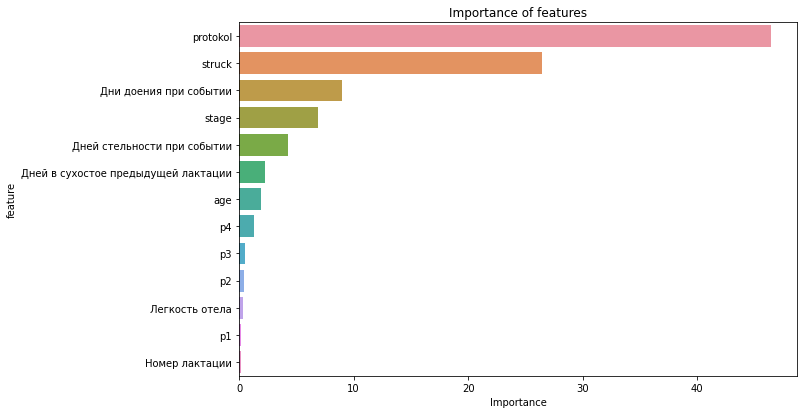

In [180]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (10, len(feature_importances) * 0.5))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
show_feature_importances(X_train.columns, model.feature_importances_)

In [181]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

      БОЛЕЕТ       0.45      0.38      0.41       557
     ЗДОРОВА       0.00      0.00      0.00       206
      ЛЕГКОЕ       0.53      0.99      0.69       150
     СРЕДНЕЕ       0.38      0.08      0.13        39
      ТРАВМА       0.44      0.15      0.22        73
     ТЯЖЕЛОЕ       0.51      0.70      0.59       649

    accuracy                           0.49      1674
   macro avg       0.38      0.38      0.34      1674
weighted avg       0.42      0.49      0.44      1674



In [185]:
from catboost import Pool
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values=explainer.shap_values(Pool(X_test, y_test, cat_features = category))

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2], X_test)

In [183]:
list(zip(X_test.columns, model.feature_importances_))

[('Номер лактации', 0.1355363074884402),
 ('Легкость отела', 0.3523130478358845),
 ('Дней в сухостое предыдущей лактации', 2.254161631050568),
 ('Дней стельности при событии', 4.284634595769819),
 ('Дни доения при событии', 9.004066537079485),
 ('protokol', 46.39568672520899),
 ('age', 1.8724941618245425),
 ('p1', 0.1694457595070261),
 ('p2', 0.4435929708861916),
 ('p3', 0.48415851388226305),
 ('p4', 1.318866124822815),
 ('struck', 26.421995111311304),
 ('stage', 6.863048513332679)]

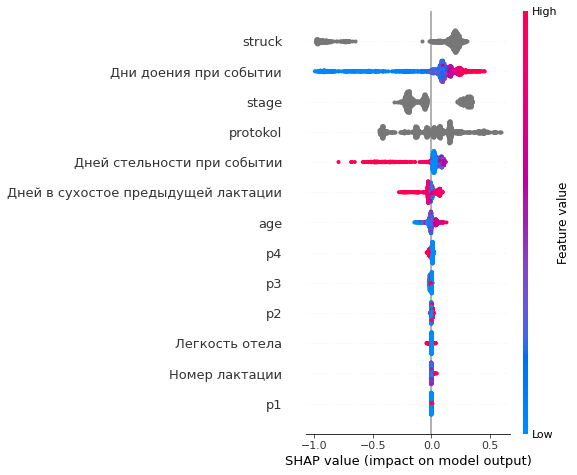

In [184]:
shap.summary_plot(shap_values[0], X_test)

In [62]:
df_cow_model.iloc[1142]

Номер лактации                            4
Легкость отела                            1
Дней в сухостое предыдущей лактации      47
Дней стельности при событии             216
Дни доения при событии                  127
protokol                                КМ5
age                                    1927
p1                                        1
p2                                        0
p3                                        0
p4                                        0
struck                                    1
result                                    3
stage                                     1
Name: 1142, dtype: object